In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from utils.ml_utils import *

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

from data_prep import load_features_data



**Load the features data, these are popular trend following features used in prior literature, this notebook assumes you have the pickle file residual_returns.pkl saved in the root directory, you can download this file from the OneDrive**

In [6]:
feats = load_features_data()
feats.tail()

ret      rVol    1d_ret   1wk_ret    1m_ret  \
date       cluster                                                      
2024-03-15 25        4.383299  0.012166 -0.017495 -0.027395 -0.000720   
           26        2.462165  0.012035 -0.001765  0.009387  0.015050   
           27        2.082460  0.012796 -0.035808 -0.060372 -0.092488   
           28       10.425301  0.012590 -0.011795  0.038502  0.142882   
           29        1.745186  0.012396 -0.012951 -0.018736  0.068956   

                      1Q_ret    6M_ret   12M_ret  feature_1d_ra  \
date       cluster                                                
2024-03-15 25       0.102992  0.072872  0.146811      -1.438042   
           26      -0.022086  0.025308 -0.005369      -0.146644   
           27      -0.037253  0.112426  0.139470      -2.798448   
           28       0.110394  0.209679  0.370151      -0.936814   
           29       0.007108 -0.013731 -0.046507      -1.044764   

                    feature_1wk_ra  ...  lag5_feature_MACD_short  \
date       cluster                  ...                            
2024-03-15 25            -1.007008  ...                 0.398363   
           26             0.348834  ...                -0.199871   
           27            -2.110060  ...                -0.032563   
           28             1.367633  ...                 0.523603   
           29            -0.675943  ...                 0.626469   

                    lag5_feature_MACD_medium  lag5_feature_MACD_long  \
date       cluster                                                     
2024-03-15 25                       0.585645                0.664800   
           26                      -0.179508                0.128255   
           27                       0.246765                0.754907   
           28                       0.554301                0.698447   
           29                       0.518373                0.183227   

                    lag5_feature_skew6m  lag5_feature_skew12m  \
date       cluster                                              
2024-03-15 25                 -0.222085              0.386809   
           26                 -0.217538              0.392190   
           27                 -0.231616              0.380269   
           28                 -0.231386              0.365261   
           29                 -0.230371              0.372743   

                    lag5_feature_kurt6m  lag5_feature_kurt12m  fwd_ret1d  \
date       cluster                                                         
2024-03-15 25                  0.580919              2.809109        NaN   
           26                  0.566987              2.789701        NaN   
           27                  0.525654              2.751046        NaN   
           28                  0.518548              2.752472        NaN   
           29                  0.519866              2.848368        NaN   

                    target  targetBin  
date       cluster                     
2024-03-15 25          NaN        NaN  
           26          NaN        NaN  
           27          NaN        NaN  
           28          NaN        NaN  
           29          NaN        NaN  

[5 rows x 89 columns]

count    174209.000000
mean          0.031924
std           1.285065
min         -19.381877
25%          -0.646536
50%           0.065431
75%           0.736927
max          16.556220
Name: target, dtype: float64


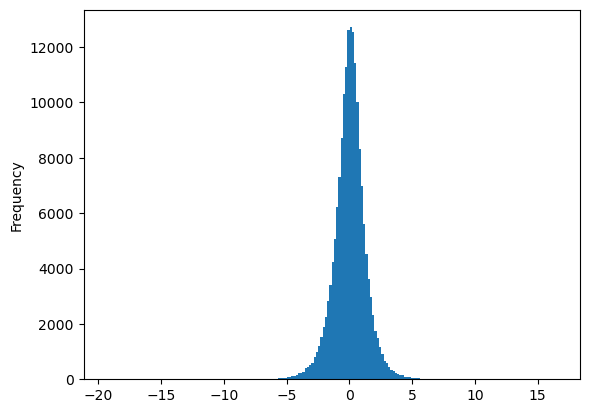

In [7]:
# distribution of tragets
feats['target'].plot(kind='hist', bins=200)
print(feats['target'].describe())

**Extract the predictive features and target, which is one day forward risk adjusted return - drop na on this subset**

In [8]:
features = [f for f in feats.columns if f.startswith("feature")]
lag_feats = [f for f in feats.columns if f.startswith("lag")]
target = ["target"]

all_feats = features + target + lag_feats
feats.dropna(subset=all_feats, inplace=True)
feats = feats[all_feats]

print("Shape of features", feats.shape)

Shape of features (166530, 79)


**Break out X and y and set up cross-validation**

In [9]:
X = feats[all_feats].copy()

baseRF = RandomForestRegressor(max_depth=5, 
                               n_estimators=1000,
                               max_features=int(1),
                               n_jobs=-3)

# simple-grid
grid = {'n_estimators': np.arange(100, 1000, 100),
        'max_depth': [3, 6, 9],
        'max_features': [int(1), 'sqrt'],
        'min_weight_fraction_leaf': np.arange(0.0, 0.05, 0.005)}

params = ParameterSampler(n_iter=25, param_distributions=grid)


**Form the training loop, here we train on 3 year expanding windows, using 90% of each split for training and 10% for tuning hyper-parameters, we then use the same model to forecast forward 3-years before re-training again.**

In [10]:
predictions = []
scores = []
for train, test in tqdm(get_cv_splits(X, split_length=252*3)):
    # break out X and y train, test
    X_train, y_train = train[features], train[target] 
    X_test, y_test = test[features], test[target]

    # hyper-param loop
    X_train2, X_val, y_train2, y_val = train_val_split(X_train, y_train)
    print(X_train2.shape, X_val.shape)

    # inner loop for parameter tuning
    gscv_scores = {'scores': [], 'grid':[]}
    for k, p in enumerate(params):
        model = RandomForestRegressor(**p)
        model.n_jobs=-1
        model.fit(X_train2, y_train2.values.reshape(y_train2.shape[0], ))
        _pred = model.predict(X_val)
        _score = mean_squared_error(y_val, _pred)
        gscv_scores['scores'].append(_score)
        gscv_scores['grid'].append(p)
        print(f'Iter: {k}: Score: {_score}')

    # now fit the best model
    best_model = pd.DataFrame(gscv_scores).sort_values(by='scores').head(1)['grid'].values[0]
    print(best_model)
    best_model = RandomForestRegressor(**best_model)
    best_model.n_jobs=-1
    best_model.fit(X_train, y_train.values.reshape(y_train.shape[0], ))
    preds = best_model.predict(X_test)

    # append the predictions
    predictions.append(pd.Series(index=y_test.index, data=preds))

    # score
    scores.append(mean_squared_error(y_test, preds))

# predictions
predictions = pd.concat(predictions).to_frame("predictions")

0it [00:00, ?it/s]

7
(20439, 13) (2250, 13)
Iter: 0: Score: 1.7067157112381892
Iter: 1: Score: 1.7001888094586748
Iter: 2: Score: 1.7024882782691417
Iter: 3: Score: 1.6875429001865059
Iter: 4: Score: 1.6930363399000479
Iter: 5: Score: 1.6884935717157101
Iter: 6: Score: 1.6966927200343656
Iter: 7: Score: 1.6937055344681218
Iter: 8: Score: 1.7025817513903632
Iter: 9: Score: 1.7000895301525905
Iter: 10: Score: 1.6995339614906761
Iter: 11: Score: 1.7075038212379787
Iter: 12: Score: 1.6920407688560644
Iter: 13: Score: 1.6879745536832835
Iter: 14: Score: 1.6984418598868478
Iter: 15: Score: 1.6878369425854578
Iter: 16: Score: 1.6923948317271396
Iter: 17: Score: 1.7031827168942404
Iter: 18: Score: 1.6918315449044035
Iter: 19: Score: 1.6928070880251544
Iter: 20: Score: 1.6904084363778822
Iter: 21: Score: 1.6932143050557544
Iter: 22: Score: 1.691467818722068
Iter: 23: Score: 1.7021555574526945
Iter: 24: Score: 1.6868596079246454
{'n_estimators': 500, 'min_weight_fraction_leaf': 0.035, 'max_features': 1, 'max_depth

1it [00:31, 31.13s/it]

(40878, 13) (4530, 13)
Iter: 0: Score: 1.8456231631408926
Iter: 1: Score: 1.849824248519922
Iter: 2: Score: 1.8447408574121438
Iter: 3: Score: 1.845967121894612
Iter: 4: Score: 1.844202125456274
Iter: 5: Score: 1.8500072031115002
Iter: 6: Score: 1.8489057020037432
Iter: 7: Score: 1.8546326555497674
Iter: 8: Score: 1.847055903149726
Iter: 9: Score: 1.8456269054813872
Iter: 10: Score: 1.8448561532289212
Iter: 11: Score: 1.8623221724605474
Iter: 12: Score: 1.8464452429643483
Iter: 13: Score: 1.847213194716945
Iter: 14: Score: 1.8436242636435038
Iter: 15: Score: 1.845505685723937
Iter: 16: Score: 1.8627076261429365
Iter: 17: Score: 1.8450401164920514
Iter: 18: Score: 1.851453901932468
Iter: 19: Score: 1.8541234886319806
Iter: 20: Score: 1.845581947255799
Iter: 21: Score: 1.8497457289297787
Iter: 22: Score: 1.8680183249481697
Iter: 23: Score: 1.8449360827696606
Iter: 24: Score: 1.845306952950792
{'n_estimators': 600, 'min_weight_fraction_leaf': 0.045, 'max_features': 1, 'max_depth': 3}


2it [01:16, 39.68s/it]

(61290, 13) (6810, 13)
Iter: 0: Score: 2.0956850822125155
Iter: 1: Score: 2.0836151011116053
Iter: 2: Score: 2.083740688340256
Iter: 3: Score: 2.0926631845014882
Iter: 4: Score: 2.0815250603799136
Iter: 5: Score: 2.080780143233509
Iter: 6: Score: 2.135454584156553
Iter: 7: Score: 2.0864467613531055
Iter: 8: Score: 2.082470695628665
Iter: 9: Score: 2.086168318282483
Iter: 10: Score: 2.0853326008590627
Iter: 11: Score: 2.0838828613865283
Iter: 12: Score: 2.0907396949198818
Iter: 13: Score: 2.081425703541327
Iter: 14: Score: 2.090774862560936
Iter: 15: Score: 2.086812608891482
Iter: 16: Score: 2.0818093781452163
Iter: 17: Score: 2.0828585009850715
Iter: 18: Score: 2.0827873421522773
Iter: 19: Score: 2.0842983250934135
Iter: 20: Score: 2.0875573761542228
Iter: 21: Score: 2.0927181480570245
Iter: 22: Score: 2.081817120682783
Iter: 23: Score: 2.088905264767806
Iter: 24: Score: 2.22072580077738
{'n_estimators': 900, 'min_weight_fraction_leaf': 0.03, 'max_features': 1, 'max_depth': 3}


3it [02:50, 64.39s/it]

(81702, 13) (9060, 13)
Iter: 0: Score: 1.661901545122424
Iter: 1: Score: 1.6491975136187906
Iter: 2: Score: 1.6498600024568755
Iter: 3: Score: 1.6409494424210873
Iter: 4: Score: 1.644591028270848
Iter: 5: Score: 1.6437374335093393
Iter: 6: Score: 1.6423768876103864
Iter: 7: Score: 1.6431829380329535
Iter: 8: Score: 1.6419388154643273
Iter: 9: Score: 1.641130691102093
Iter: 10: Score: 1.640864590101489
Iter: 11: Score: 1.641206877792399
Iter: 12: Score: 1.6419073586350463
Iter: 13: Score: 1.6430542780204975
Iter: 14: Score: 1.6436306155501255
Iter: 15: Score: 1.6453358222567667
Iter: 16: Score: 1.6423991755648981
Iter: 17: Score: 1.647583071114909
Iter: 18: Score: 1.6476229864200809
Iter: 19: Score: 1.6432880301376624
Iter: 20: Score: 1.6439595253249093
Iter: 21: Score: 1.6419531535797034
Iter: 22: Score: 1.641034440688348
Iter: 23: Score: 1.6438735149013388
Iter: 24: Score: 1.6472372079854647
{'n_estimators': 900, 'min_weight_fraction_leaf': 0.015, 'max_features': 1, 'max_depth': 6}


4it [05:14, 95.68s/it]

(102114, 13) (11340, 13)
Iter: 0: Score: 1.4986601715768522
Iter: 1: Score: 1.4990093033359861
Iter: 2: Score: 1.500121753552582
Iter: 3: Score: 1.4996550593483144
Iter: 4: Score: 1.4998997375715488
Iter: 5: Score: 1.4989918348344045
Iter: 6: Score: 1.5011871733677353
Iter: 7: Score: 1.4990605216786446
Iter: 8: Score: 1.5000177109199955
Iter: 9: Score: 1.4984443360453852
Iter: 10: Score: 1.4992165341752781
Iter: 11: Score: 1.4989588019670803
Iter: 12: Score: 1.4982866590656012
Iter: 13: Score: 1.5009921158014392
Iter: 14: Score: 1.5011921946753073
Iter: 15: Score: 1.4992376337405324
Iter: 16: Score: 1.499503417753071
Iter: 17: Score: 1.4984111279148147
Iter: 18: Score: 1.5011673258182805
Iter: 19: Score: 1.5001268617495738
Iter: 20: Score: 1.4988464437752234
Iter: 21: Score: 1.498867782443324
Iter: 22: Score: 1.5004142503137732
Iter: 23: Score: 1.5002142155298743
Iter: 24: Score: 1.49956529261722
{'n_estimators': 400, 'min_weight_fraction_leaf': 0.03, 'max_features': 1, 'max_depth': 3}

5it [08:00, 121.29s/it]

(122526, 13) (13590, 13)
Iter: 0: Score: 1.547503721533557
Iter: 1: Score: 1.5463617736309678
Iter: 2: Score: 1.5464660116882731
Iter: 3: Score: 1.548154115684309
Iter: 4: Score: 1.5476433789896638
Iter: 5: Score: 1.5445823837814998
Iter: 6: Score: 1.546700181778055
Iter: 7: Score: 1.5451808337960655
Iter: 8: Score: 1.5481110184942835
Iter: 9: Score: 1.5476216480394216
Iter: 10: Score: 1.543019505773923
Iter: 11: Score: 1.5464064986477717
Iter: 12: Score: 1.5468908422237968
Iter: 13: Score: 1.546842185797818
Iter: 14: Score: 1.5462024224897521
Iter: 15: Score: 1.5467771294417
Iter: 16: Score: 1.5476425434127312
Iter: 17: Score: 1.5476244403638681
Iter: 18: Score: 1.5480227616655071
Iter: 19: Score: 1.546966660995265
Iter: 20: Score: 1.5443364093753684
Iter: 21: Score: 1.5451832148871214
Iter: 22: Score: 1.546338138555925
Iter: 23: Score: 1.54765843645707
Iter: 24: Score: 1.5481216606550505
{'n_estimators': 700, 'min_weight_fraction_leaf': 0.0, 'max_features': 'sqrt', 'max_depth': 3}


6it [11:11, 144.79s/it]

(142938, 13) (15870, 13)
Iter: 0: Score: 1.4978638544257261
Iter: 1: Score: 1.4976873071670471
Iter: 2: Score: 1.5013830379952091
Iter: 3: Score: 1.4977130384517487
Iter: 4: Score: 1.4977170253489809
Iter: 5: Score: 1.4983747980554012
Iter: 6: Score: 1.4979807165890873
Iter: 7: Score: 1.5001907902438112
Iter: 8: Score: 1.4978785060724105
Iter: 9: Score: 1.498935449184094
Iter: 10: Score: 1.5018241557226002
Iter: 11: Score: 1.4978658588596825
Iter: 12: Score: 1.5001903011709259
Iter: 13: Score: 1.4978989338104685
Iter: 14: Score: 1.4987329344713554
Iter: 15: Score: 1.497991154095187
Iter: 16: Score: 1.497660199865212
Iter: 17: Score: 1.5017690914646862
Iter: 18: Score: 1.5059661138821054
Iter: 19: Score: 1.4975208166759966
Iter: 20: Score: 1.4995917285638511
Iter: 21: Score: 1.498288104362474
Iter: 22: Score: 1.498687670953373
Iter: 23: Score: 1.4981498936071067
Iter: 24: Score: 1.4993401474523174
{'n_estimators': 300, 'min_weight_fraction_leaf': 0.045, 'max_features': 1, 'max_depth': 6

7it [15:07, 129.62s/it]


**Check distribution of the targets**

<Axes: title={'center': 'distribution of predictions'}, ylabel='Frequency'>

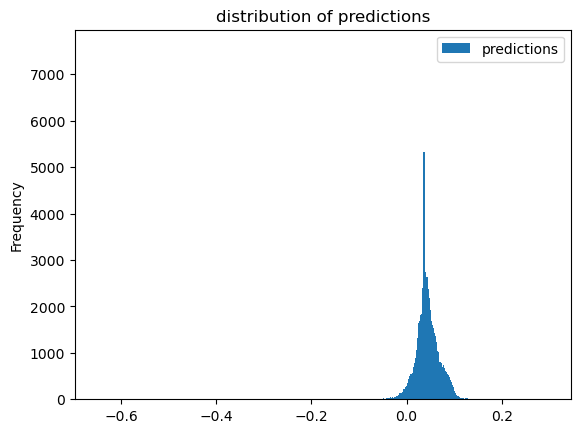

In [11]:
# We can see predictions go negative at about the 25% percentile, market mainly goes up
predictions.plot(kind='hist', bins=1000, title="distribution of predictions")

**Join in predictions with the original dataset which has the cluster returns**

In [12]:
# bring in the data
data = load_features_data()

# join in predictions
predictions = predictions.merge(data, how="left", left_index=True, right_index=True)
predictions.sort_index(inplace=True)

**On each day divide the predictions into quartiles and compute the mean return, the top quartile should be the highest predicted cluster returns**

In [13]:
predictions['signalQ'] = predictions.groupby(by='date')['predictions'].apply(lambda x: pd.qcut(x, 4, labels=False)).droplevel(0)

# shift signal back by one day
predictions['signalQ'] = predictions.groupby(by='cluster')['signalQ'].shift(1)
rets = predictions.groupby(by=['date', 'signalQ'])['1d_ret'].mean().unstack()

**Group by signalQ shifted back by one day and then compute the average return, unstack to get time series of mean cluster returns by signal quartile. Compute portfolio returns with the utils function**

In [14]:
rets = predictions.groupby(by=['date', 'signalQ'])['1d_ret'].mean().unstack()
rets.rename(columns={col: f'Q_{col}' for col in rets.columns}, inplace=True)

get_returns_breakout(rets)

,Annual_Return,Annual_Volatility,DD,MDD,Sharpe,Sortino,Calmar,ppct_postive_rets
Q_0.0,0.071786,0.230925,0.165413,-0.607829,0.416302,0.581179,0.118103,0.536244
Q_1.0,0.058308,0.227183,0.163895,-0.630926,0.363684,0.504119,0.092417,0.539377
Q_2.0,0.069817,0.227881,0.162462,-0.563826,0.410567,0.575892,0.123827,0.53708
Q_3.0,0.07494,0.22944,0.163463,-0.565244,0.430165,0.603786,0.132579,0.536244


<Axes: title={'center': 'Cumulative Strategy Returns'}, xlabel='date'>

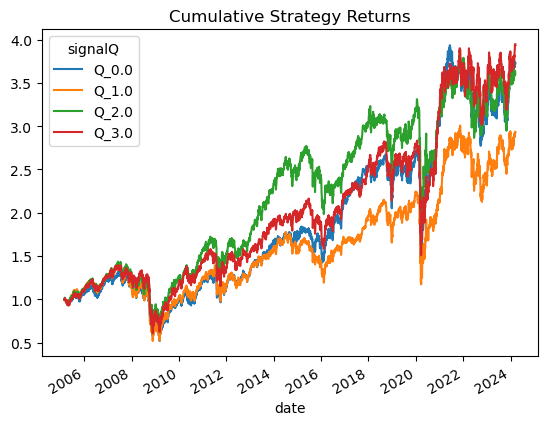

In [15]:
# plot the returns
(1 + rets).cumprod().plot(title="Cumulative Strategy Returns")